In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
import pathlib, glob
from scipy.stats import norm

In [16]:
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, slice_volume, rotate_volume, take_slice
from scipy.interpolate import RegularGridInterpolator, griddata

Make sure we have a local directory to read the data from, and that the data is there

In [4]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
output_dir = data_directory / 'test'
if output_dir.exists():
    print(f'Data directory {output_dir} exists: ')
    for x in list(output_dir.glob('*')):
        print(f'>>> {str(x)}') 

Data directory ../data/test exists: 
>>> ../data/test/particle_hires_xyz.npy
>>> ../data/test/particle_hires_map.npy
>>> ../data/test/particle_meta.npy
>>> ../data/test/particle_hires_data.npy
>>> ../data/test/particle_hires_meta.npy
>>> ../data/test/particle_map.npy
>>> ../data/test/particle_xyz.npy
>>> ../data/test/particle_data.npy


Pick a dataset by its keyword

In [5]:
keyword='particle'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

Let's have a look at the structure

In [7]:
ipv.quickscatter(structure[:,0], structure[:,1], structure[:,2], size=10*structure[:,3], marker='sphere')

Now let's check the volume

In [7]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

/Users/fpoitevi/miniconda3/envs/gmm-cryoem/lib/python3.7/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


And now a few of the projection images

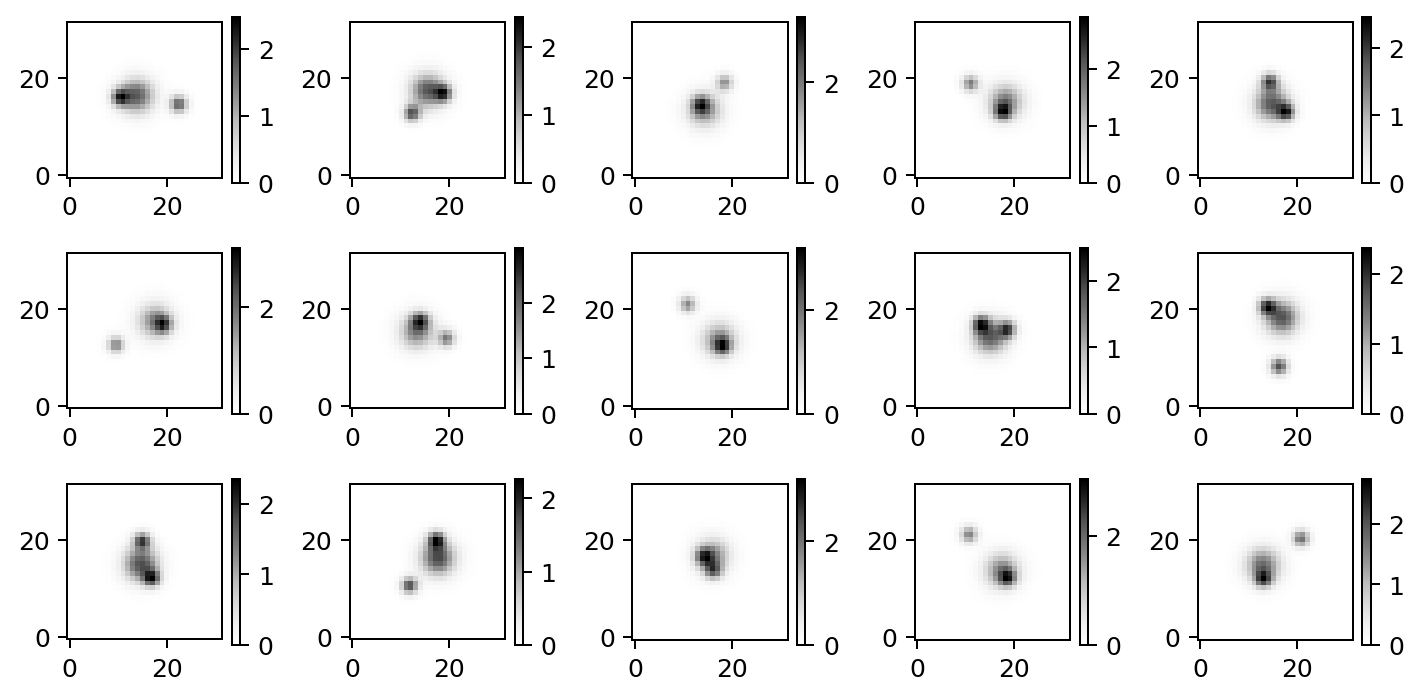

In [8]:
nrows=3
ncols=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4), dpi=180)
k=0
for i in np.arange(nrows):
    for j in np.arange(ncols):
        #axes[i,j].plot(metadataset[k,0:3])
        ax = axes[i,j]
        ims = ax.imshow(dataset[k], cmap='Greys', origin='lower')
        fig.colorbar(ims, ax=ax)
        k+=1
plt.tight_layout()
plt.show()

# Projections
We now look into projections where instead of rotating the particle, we rotate the slicing plane

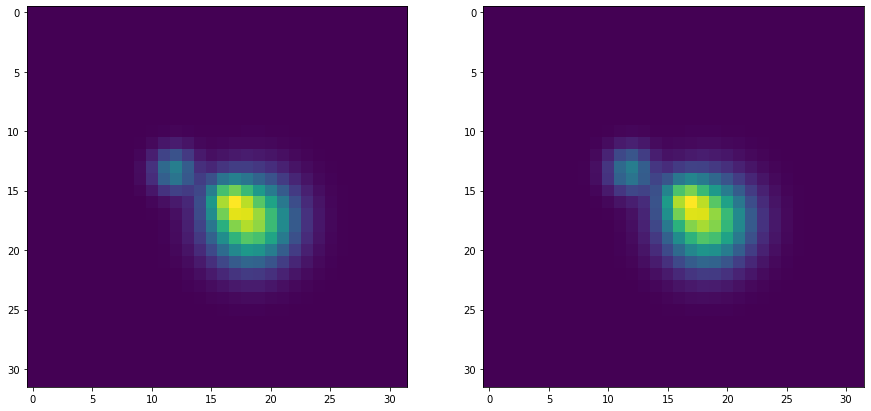

In [52]:
i=12
Rot = R.from_rotvec(-metadataset[i,0:3])
projection = project_volume(volume, Rot)

fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(dataset[i])
ax[1].imshow(projection)

In [7]:
#Note from Fred: j'en suis la. J'ai pas eu le temps de finir...

In [26]:
def create_circular_mask(N, is_volume=False, radius=None, all_masks = False):
    """
    I dont use it anywhere at the moment...
    """
    if not(is_volume):
        center = (int(N/2), int(N/2))
        Y, X = np.ogrid[:N, :N]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    else:
        center = (int(N/2), int(N/2), int(N/2))
        Z, Y, X = np.ogrid[:N, :N, :N]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2+ (Z-center[1])**2)
        
    mask = (dist_from_center < radius)
    if (all_masks):
        mask_strict = dist_from_center <= radius
        mask_equal = (dist_from_center == radius)
        return mask_strict, mask_equal, mask
    else:
        return mask

In [70]:
def backprojection(images, orientations):
    
    N=images[0].shape[0]
    vol = np.zeros((N,N,N),  dtype=np.complex)
    counts = np.zeros((N,N,N))
    
    for i in range(len(images)):
        #adding the contribution of each slices/images
        rot = R.from_rotvec(-orientations[i])
        image_i=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(images[i])))
        vol, counts = add_slice(vol, counts, image_i, rot)
    
    counts[counts == 0] = 1
    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(vol/counts))))


def lattice_create_circular_mask(lattice, N, radius=None):
    """
    Mask for vectors with real cordinates.
    We'll use this function to work with the unit ball instead of the whole volume.
    """
    if radius is None:
        radius = 1
    dist_from_center = np.sqrt((lattice[:,0])**2 + (lattice[:,1])**2 + (lattice[:,2])**2)
    mask = (dist_from_center < radius)
    return mask
    
    
def add_slice(vol, counts, image, rot):
    """
    This function adds an image to the volume, by updating the values of the pixels arround the slice.
    """
    N = vol.shape[0]
    image=image.reshape((N*N,1))
    d2 = int(N/2)
    
    #building rotated lattice
    x = np.linspace(-1,1,N)
    y = np.linspace(-1,1,N)
    grid_x, grid_y = np.meshgrid(x,y, indexing='ij')
    zeros = np.zeros((grid_x.shape))
    points = np.stack([grid_x.ravel(),grid_y.ravel(), zeros.ravel()],1)
    rot_points = rot.apply(points)
    
    #coordinates of the adjacent voxels
    points_f = (np.floor(rot_points*d2))/d2
    mask_f = lattice_create_circular_mask(points_f, N, radius=None)
    points_c = (np.ceil(rot_points*d2))/d2
    mask_c = lattice_create_circular_mask(points_c, N, radius=None)
    
    #By mixing the floor values and the ceil values, we can browse all adjacent voxels
    #we only keep the points that are inside the unit ball
    xf, yf, zf = np.split(points_f[(mask_f) & (mask_c)],3,1)
    xc, yc, zc = np.split(points_c[(mask_f) & (mask_c)],3,1)

    def add_for_corner(xi,yi,zi):
        """
        This auxilliary function add the contribution of the slice to a set of adjacent voxels
        """
        dist = np.stack((xi,yi,zi), axis=1)[:,:,0] - rot_points[(mask_f) & (mask_c)]
        w = 1 - np.sqrt(np.sum(np.power(dist, 2), axis=1))
        w[w<0]=0
        w=w.reshape((-1, 1))
        vol[(xi*d2+d2).astype(int),(yi*d2+d2).astype(int),(zi*d2+d2).astype(int)] += (w*image[(mask_f) & (mask_c)])
        counts[(xi*d2+d2).astype(int),(yi*d2+d2).astype(int),(zi*d2+d2).astype(int)] += w
    
    #calling the auxilliary function for all adjacent voxels
    add_for_corner(xf,yf,zf)
    add_for_corner(xc,yf,zf)
    add_for_corner(xf,yc,zf)
    add_for_corner(xf,yf,zc)
    add_for_corner(xc,yc,zf)
    add_for_corner(xf,yc,zc)
    add_for_corner(xc,yf,zc)
    add_for_corner(xc,yc,zc)
    
    return vol, counts

In [74]:
vol = backprojection(dataset[:10], metadataset[:100,0:3])

In [75]:
ipv.quickvolshow(vol, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [73]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

/Users/michaelresplandy/miniconda3/envs/gmm-cryoem/lib/python3.6/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


In [107]:
def proba(projected_vol, image):
    """
    This function calculates a probability score to tell how close two images are.
    """
    return np.prod((1-norm.cdf(np.abs(projected_vol-image), loc=0, scale=100))*2)

def reconstruct(dataset, vols, angle_step, heterogeneity = False):
    """
    This function reconstructs the models at step t+1 given the models at step t
    To long, probably need to be optimize
    """
    alphas = np.linspace(0,360,angle_step)
    betas = np.linspace(0,360,angle_step)
    gammas = np.linspace(0,360,angle_step)
    counts = np.zeros(vols.shape, dtype=complex)
    next_models = np.zeros(vols.shape, dtype=complex)
    
    if (heterogeneity):
        probs = np.zeros((vols.shape[0]))
    else:
        probs = 0
    for i in range(len(dataset)):
        print(i)
        if (i+1)%10 == 0:
            print(i+1)
            
        for alpha in alphas:
            for beta in betas:
                for gamma in gammas:
                    rot = R.from_euler(seq='zyx', angles=np.array((alpha, beta, gamma)))
                    projected_vol = project_volume(vol, rot)
                    if heterogeneity:      
                        for k in range(vols.shape[0]):
                            prob = proba(projected_vol, dataset[i])
                            images_i = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(dataset[i])))
                            probs[k]+= prob
                            next_models[k], counts[k] = add_slice(next_models[k], counts[k], prob*images_i, rot) 
                            #we add the image, weighed by the probabity
                            #to construct the models at the next iteration
                    else:
                        prob = proba(projected_vol, dataset[i])                                      
                        images_i = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(dataset[i])))
                        probs+= prob
                        next_models, counts = add_slice(next_models, counts, prob*images_i, rot)
    
    counts[counts == 0] = 1
    if (heterogeneity):
        for k in range(models.shape[0]):
            next_models[k] = next_models[k]/probs[k]
            next_models[k] = next_models[k]/counts[k]
        
                                                        
    else:
        next_models = next_models/probs    
        next_models = next_models/counts    

        
    return next_models

def EM(dataset, models_init, eps=1, n_steps=10, angle_step=10):
    """
    This function iterates the reconstruct function to converge to a local optimum
    """
    models = models_init
    step = 0
    end = False
    while step<n_steps and not(end):
        print('step:' +str(step+1))
        next_models = reconstruct(dataset, models, theta_step)
        step +=1
        if np.sum(np.abs(next_models - models)) < eps:
            end = True
        else:
            models = next_models
    
    return next_models

In [108]:
vol_ = reconstruct(dataset[:100], np.fft.fftshift(np.fft.fftn(vol)), 10)

0
1
2
3
4
5
6
7
8
9
10
10
11
12
13
14
15
16
17
18
19
20
20
21
22
23
24
25
26
27
28
29
30
30
31
32
33
34
35
36
37
38
39
40
40


KeyboardInterrupt: 

In [84]:
ipv.quickvolshow(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(vol_))).real, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)

In [85]:
ipv.quickvolshow(volume, level=[0.25, 0.75], opacity=[0.03, 0.2], level_width=0.1)